### Assignment 4 - Clustering the Iris Datatset

Importing all libraries and loading the dataset

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from pandas.plotting import scatter_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist, pdist
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns

In [2]:
url = "https://raw.githubusercontent.com/cs6220/cs6220.spring2019/master/data/" 
names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width", "Name"] 
df = pd.read_csv(url + "iris.data", header=None, names=names)

In [3]:
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 1.1 Clustering Data with k-means

**Plot a scatter plot matrix between all features (see pandas.plotting.scatter matrix). Use the “Name” column to color the points. Note that you may have to convert the “Name” column into integers to use it for specifying the plot colors (see the ‘c’ parameter). Resize the plot as needed.**

using pd.factorize(df['Name'])[0] to convert the Names column to integers. (Thanks Evaraldo!)

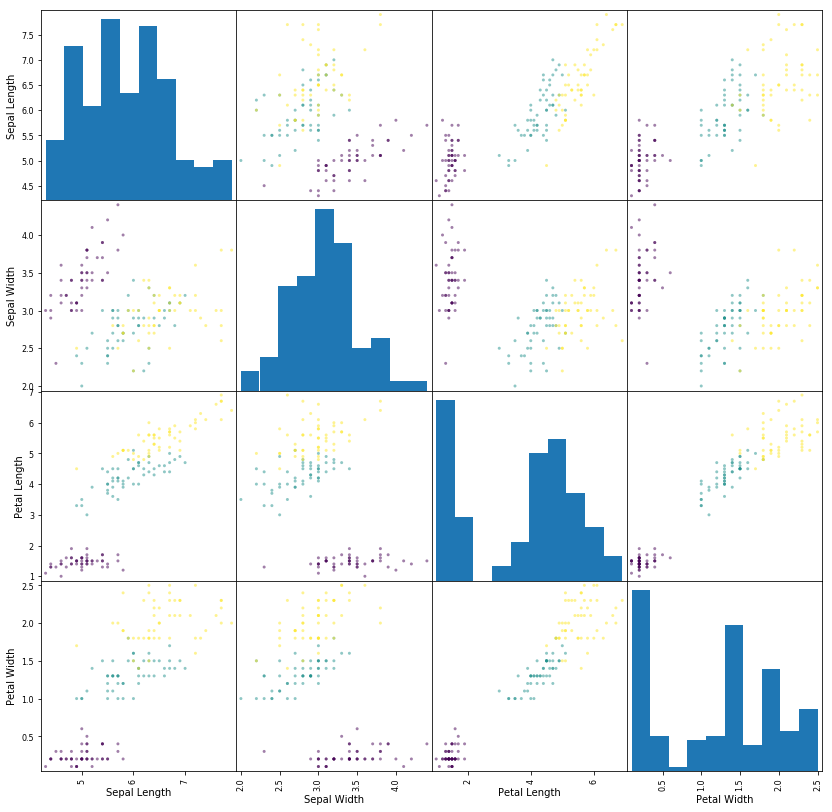

In [4]:
pd.plotting.scatter_matrix(df, figsize=(14, 14), c=pd.factorize(df['Name'])[0]);

Better looking, better colored matrix plot with Seaborn!

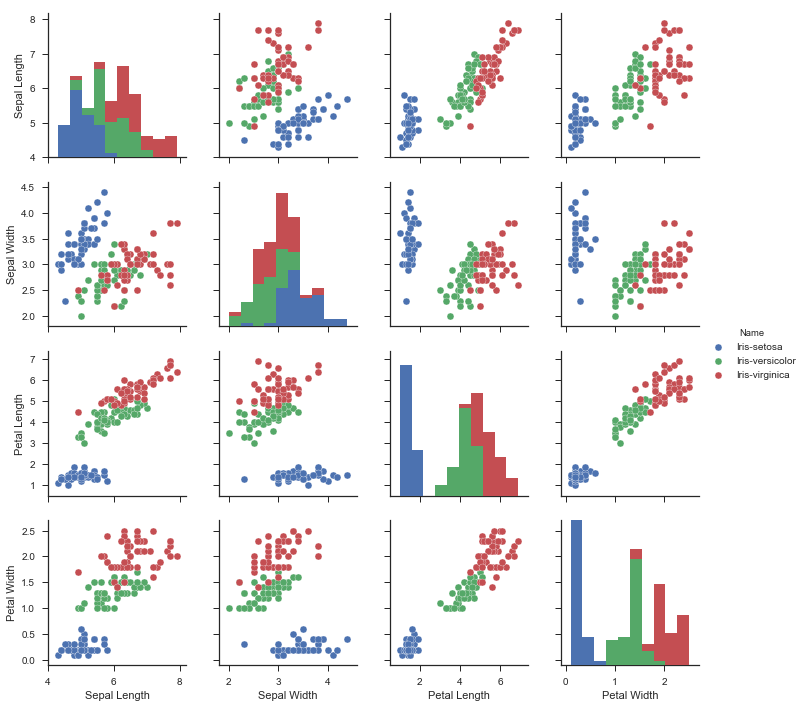

In [5]:
sns.set(style="ticks")
sns.pairplot(df, hue="Name");

**Do the three classes appear to be equally well-separated or is one more different than the others?**

Based on all of the features, the Iris-Setosa class seems to be more separated. The other two classes are very close to each other in all the different plottings.

**Cluster the the data using k-Means clustering (see sklearn.cluster.KMeans). Form 3 clusters (n clusters=3), with the four features as the input data, and plot the resulting clusters as a 2D scatter plot. Use “Petal Length” for the x-axis of the plot and “Petal Width” for the y-axis, with each point colored according to its assigned cluster label.**

In [6]:
kmeans = KMeans(n_clusters=3)
# 4 features as the input data for the model
kmeans.fit(df.drop(['Name'], axis=1))
y_pred = kmeans.predict(df.drop(['Name'], axis=1))

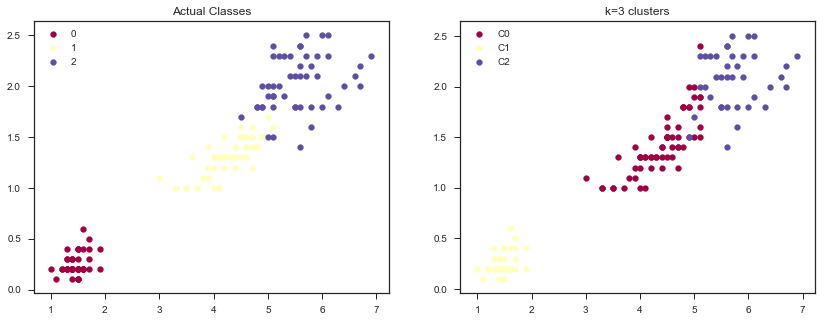

In [7]:
def plot_cluster_pred_vs_true(X, y, y_clusters, n_true):
    """Compare clustering vs. actual."""
    fig = plt.figure(figsize=(14, 5))

    cmap = cm.get_cmap('Spectral')
    colors = cmap(np.linspace(0, 1, n_true))

    ax = fig.add_subplot(121)
    for i in range(n_true):
        idx = y == i
        ax.scatter(X[idx, 0], X[idx, 1], s=35, c=[colors[i]],
                   label='{:d}'.format(i))
    plt.legend()
    plt.title('Actual Classes')

    ax = fig.add_subplot(122)
    for i in range(n_true):
        idx = y_clusters == i
        ax.scatter(X[idx, 0], X[idx, 1], s=35, c=[colors[i]],
                   label='C{:d}'.format(i))
    plt.legend()
    plt.title('k={:d} clusters'.format(n_true))

    plt.show()

# 'Petal Length' for x-axis and 'Petal Width' for y-axis
X = [[df['Petal Length'][i],df['Petal Width'][i]] for i in range(len(df))]
y = pd.factorize(df['Name'])[0]
plot_cluster_pred_vs_true(np.array(X), np.array(y), y_pred, 3)

**Show the cross-tabulation (see pandas.crosstab) of the actual class values and the cluster labels. How many instances belong to an incorrect cluster?**


In [8]:
crosstab_df = pd.crosstab(pd.factorize(df['Name'])[0], y_pred)
crosstab_df

col_0,0,1,2
row_0,,,
0,0,50,0
1,48,0,2
2,14,0,36


In [9]:
crosstab_df.set_index(df['Name'].unique())

col_0,0,1,2
Iris-setosa,0,50,0
Iris-versicolor,48,0,2
Iris-virginica,14,0,36


14 instances of Iris-virginica are in the wrong cluster and 2 instances of Iris-versicolor are in the wrong cluster.

**Do any of the cluster labels correspond perfectly to a class label? Do these observations agree with what you observed from the scatter plot matrix?**

YES and YES! 
Iris-Setosa has clustered out perfectly and the cluster labels correspond perfectly to the original class label.
This is also what I observed in the scatter plot matrix.

## 1.2 Hierarchical Clustering of Features

**To assess how similar the features are, calculate the mutual information between all pairs of features (see sklearn.feature selection.mutual info regression); that is, use each feature as the target variable once in the calculation. Create a DataFrame from the output and label the indices and columns of the DataFrame with the appropriate feature names.**

Estimated mutual information between each feature and the target.

In [10]:
from sklearn.feature_selection import mutual_info_regression as mi

In [11]:
columns = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width",]
mi_df = pd.DataFrame()
for column in columns:
    new_df = pd.DataFrame([mi([x[:-1] for x in df.values], df[column].values)],columns=columns)
    mi_df = mi_df.append(new_df)
mi_df['columns'] = columns
mi_df.set_index('columns', inplace=True)
mi_df

,Sepal Length,Sepal Width,Petal Length,Petal Width
columns,,,,
Sepal Length,3.240075,0.297955,0.854681,0.614851
Sepal Width,0.319565,2.631962,0.363227,0.419121
Petal Length,0.863469,0.353161,3.138792,1.232016
Petal Width,0.620742,0.395511,1.173513,2.779003


**Create a dendrogram from the mutual information DataFrame.**

In [12]:
def plot_dendrogram(model, **kwargs):
    children = model.children_
    dist = np.arange(children.shape[0])+1
    n_obs = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, dist, n_obs])
    dendrogram(linkage_matrix.astype(float), **kwargs)

In [13]:
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(mi_df)
features = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

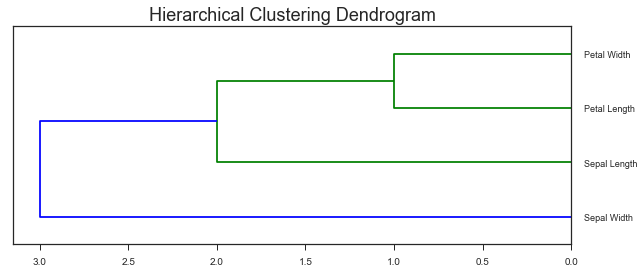

In [17]:
y_blobs = mi_df.index
figure = plt.figure(figsize=(10, 4))
plt.title("Hierarchical Clustering Dendrogram", fontsize=18)
plot_dendrogram(model, labels=y_blobs, orientation='left', leaf_font_size=9) 
plt.show()

** According to the dendrogram, which pair of features are most similar? Which feature is most unlike the others?**

Petal Width and Petal Length are most similar to each other. Sepal width is most unlike the others! 